# AutoEncoders on Fashion MNIST

**The notebook has been adapted from the notebook provided in David Foster's Generative Deep Learning, 2nd Edition.**

- Book: [Amazon](https://www.amazon.com/Generative-Deep-Learning-Teaching-Machines/dp/1098134184/ref=sr_1_1?keywords=generative+deep+learning%2C+2nd+edition&qid=1684708209&sprefix=generative+de%2Caps%2C93&sr=8-1)
- Original notebook (tensorflow and keras): [Github](https://github.com/davidADSP/Generative_Deep_Learning_2nd_Edition/blob/main/notebooks/03_vae/01_autoencoder/autoencoder.ipynb)

In [2]:
import numpy as np

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as Transforms
from torchsummary import summary

from matplotlib import pyplot as plt

## 0. Train parameters

In [3]:
IMAGE_SIZE = 32
CHANNELS = 1
BATCH_SIZE = 128
EMBEDDING_DIM = 2
EPOCHS = 10
LEARNING_RATE = 1e-3

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(DEVICE)

cuda


In [4]:
def get_dataloaders():

    # first define a transform function, to turn images into tersors
    transform = Transforms.Compose([
                    Transforms.ToTensor(),
                    Transforms.Pad(2)])

    # load MNIST dataset
    train_ds = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                          download=True, transform=transform)
    test_ds = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                         download=True, transform=transform)
    train_loader = DataLoader(dataset=train_ds, batch_size=BATCH_SIZE,
                              shuffle=True, num_workers=4)
    test_loader = DataLoader(dataset=test_ds, batch_size=BATCH_SIZE,
                              shuffle=False, num_workers=4)
    return train_loader, test_loader

In [5]:
train_loader, test_loader = get_dataloaders()
print(next(iter(train_loader))[0].shape)

torch.Size([128, 1, 32, 32])


## 2. Build the AutoEncoder

In [6]:
# Encoder
class Encoder(nn.Module):

    def __init__(self, latents):
        super().__init__()
        self.latents = latents
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(in_features=2048, out_features=self.latents)
        )

    def forward(self, x):
        return self.model(x)

# encoder = Encoder(EMBEDDING_DIM).to(DEVICE)
# summary(encoder, (1, 32, 32))

# Decoder
class Decoder(nn.Module):
    
    def __init__(self, latents):
        super().__init__()
        self.latents = latents
        self.fc = nn.Linear(self.latents, 2048)

        self.model = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128, out_channels=128, 
                               kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=128, out_channels=64, 
                               kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=64, out_channels=32, 
                   kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=1, kernel_size=3, stride=1, padding=1)
        )

    def forward(self, x):
        x = self.fc(x)
        x = x.reshape(x.shape[0], 128, 4, 4)
        x = self.model(x)
        return x

# decoder = Decoder(EMBEDDING_DIM).to(DEVICE)
# summary(decoder, (EMBEDDING_DIM,))

In [7]:
# AutoEncoder
class AE(nn.Module):
    def __init__(self, latents):
        super().__init__()
        self.encoder = Encoder(latents)
        self.decoder = Decoder(latents)

    def forward(self, x):
        z = self.encoder(x)
        recon_x = self.decoder(z)      
        return recon_x

    def generate(self, z):
        return F.sigmoid(self.decoder(z))

ae = AE(EMBEDDING_DIM).to(DEVICE)
summary(ae, (1, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 16, 16]             320
              ReLU-2           [-1, 32, 16, 16]               0
            Conv2d-3             [-1, 64, 8, 8]          18,496
              ReLU-4             [-1, 64, 8, 8]               0
            Conv2d-5            [-1, 128, 4, 4]          73,856
              ReLU-6            [-1, 128, 4, 4]               0
           Flatten-7                 [-1, 2048]               0
            Linear-8                    [-1, 2]           4,098
           Encoder-9                    [-1, 2]               0
           Linear-10                 [-1, 2048]           6,144
  ConvTranspose2d-11            [-1, 128, 8, 8]         147,584
             ReLU-12            [-1, 128, 8, 8]               0
  ConvTranspose2d-13           [-1, 64, 16, 16]          73,792
             ReLU-14           [-1, 64,

## 3. Define the model, objective, and optimizer

In [8]:
ae = AE(EMBEDDING_DIM).to(DEVICE)

if torch.__version__.split('.')[0] == '2':
    torch.set_float32_matmul_precision('high')
    ae = torch.compile(ae) # PyTorch 2.0 feature
    print('model compiled')

loss_fn = nn.BCEWithLogitsLoss(reduction='mean')
optim = torch.optim.Adam(ae.parameters(), lr=LEARNING_RATE)

model compiled


## 4. Get dataloaders

In [9]:
train_loader, test_loader = get_dataloaders()

## 5. Define train and validation functions

In [10]:
# A single epoch train funcion
def train(model, dataloader, optimizer, loss_fn):

    model.train()
    train_loss = 0

    for i, (train_x, train_y) in enumerate(dataloader):
        optimizer.zero_grad()
        train_x = train_x.to(DEVICE)
        recon_x = model(train_x)
        loss = loss_fn(recon_x, train_x)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    return train_loss / len(dataloader)

# Validation function
def validate(model, dataloader, loss_fn):
    
    model.eval()
    test_loss = 0
    for i, (test_x, test_y) in enumerate(dataloader):
        test_x = test_x.to(DEVICE)
        with torch.no_grad():
            recon_x = model(test_x)
            loss = loss_fn(recon_x, test_x)

        test_loss += loss
    return test_loss / len(dataloader)

## 6. Train and evaluate

In [11]:
for i in range(EPOCHS):
    train_loss = train(ae, train_loader, optim, loss_fn)
    test_loss = validate(ae, test_loader, loss_fn)

    print(f'Epoch {i + 1}')
    print(f'\tTrain - loss: {train_loss:.4f}')
    print(f'\tValid - loss: {test_loss:.4f}')

Epoch 1
	Train - loss: 0.2962
	Valid - loss: 0.2623
Epoch 2
	Train - loss: 0.2580
	Valid - loss: 0.2570
Epoch 3
	Train - loss: 0.2546
	Valid - loss: 0.2546
Epoch 4
	Train - loss: 0.2526
	Valid - loss: 0.2533
Epoch 5
	Train - loss: 0.2514
	Valid - loss: 0.2524
Epoch 6
	Train - loss: 0.2502
	Valid - loss: 0.2508
Epoch 7
	Train - loss: 0.2492
	Valid - loss: 0.2504
Epoch 8
	Train - loss: 0.2485
	Valid - loss: 0.2500
Epoch 9
	Train - loss: 0.2479
	Valid - loss: 0.2492
Epoch 10
	Train - loss: 0.2473
	Valid - loss: 0.2487


## 7. Embed using `Encoder`

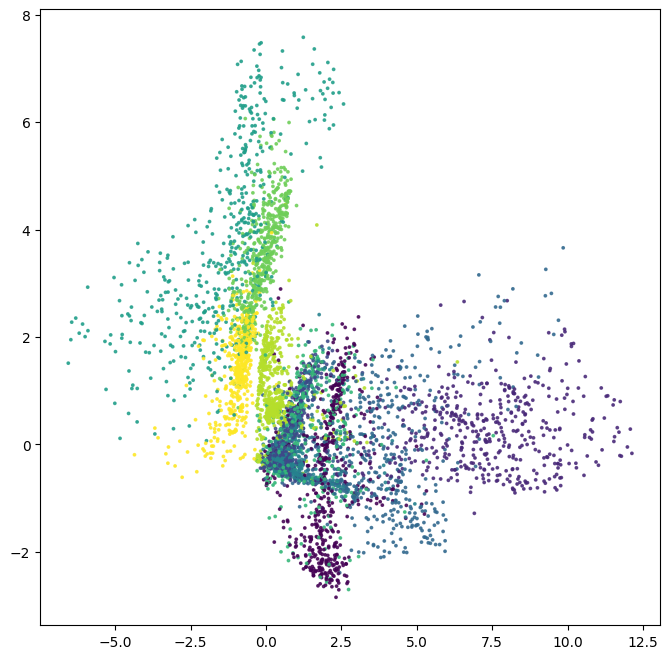

In [12]:
num_samples = 5000
num_iters = np.ceil(num_samples / BATCH_SIZE).astype(int)

for i, (test_x, test_y) in enumerate(test_loader):
    test_x = test_x.to(DEVICE)
    with torch.no_grad():
        embeddings = ae.encoder(test_x)
    if i == 0:
        output_embs = embeddings
        output_labels = test_y
    else:
        output_embs = torch.concatenate([output_embs, embeddings])
        output_labels = torch.concatenate([output_labels, test_y])
    if i == num_iters - 1: break

output_embs = output_embs.detach().cpu().numpy()
output_labels = output_labels.detach().cpu().numpy()

plt.figure(figsize=(8, 8))
plt.scatter(output_embs[:, 0], 
            output_embs[:, 1], 
            c=output_labels, 
            alpha=0.8,
            s=3)
plt.show()

## 8 Generate using `Decoder`

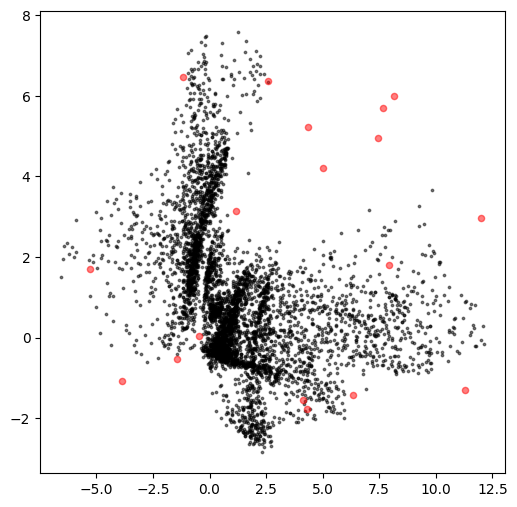

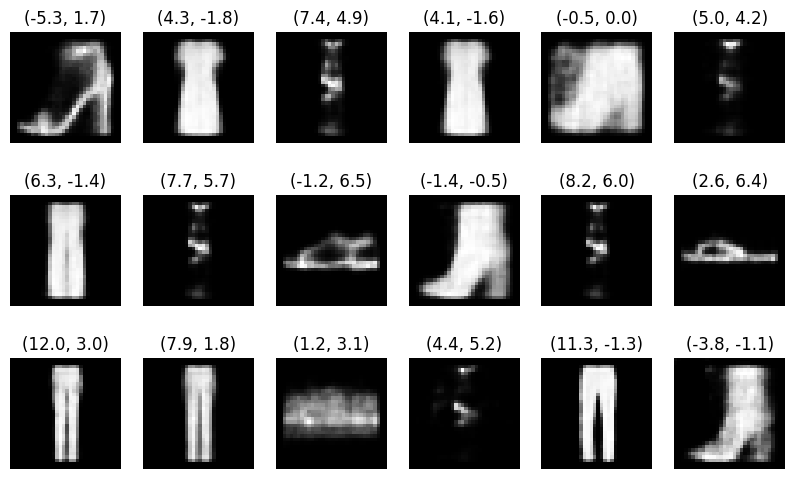

In [13]:
# Sampling from the embedding space
x_min, x_max = output_embs[:, 0].min(), output_embs[:, 0].max()
y_min, y_max = output_embs[:, 1].min(), output_embs[:, 1].max()

xs = np.random.uniform(x_min, x_max, size=(18, 1))
ys = np.random.uniform(y_min, y_max, size=(18, 1))
samples = np.hstack([xs, ys])

samples_torch = torch.tensor(samples, device=DEVICE, dtype=torch.float32)
# print(samples.shape)
with torch.no_grad():
    output_imgs = ae.generate(samples_torch).detach().cpu().numpy()
output_imgs = output_imgs.transpose((0, 2, 3, 1))

plt.figure(figsize=(6, 6))
plt.scatter(output_embs[:, 0], 
            output_embs[:, 1], 
            c='black', 
            alpha=0.5,
            s=3)
plt.scatter(samples[:, 0], 
            samples[:, 1], 
            c='red', 
            alpha=0.5,
            s=20)
plt.show()

# Generate new images from sampled embeddings
fig, axes = plt.subplots(nrows=3, ncols=6, figsize=(10, 6))
for i in range(output_imgs.shape[0]):
    curr_row = i // 6
    curr_col = i % 6
    ax = axes[curr_row, curr_col]
    
    ax.set_title(f'({samples[i][0]:.1f}, {samples[i][1]:.1f})')
    ax.axis('off')
    ax.imshow(output_imgs[i], cmap='gray')

plt.show()